In [168]:
#libreria para manejo de NDARRAY
import numpy as np;
#libreria para graficar
#tipo matlab: pyplot
#objetual: figure, axes
import matplotlib.pyplot as plt
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd

In [2]:

ruta_carpeta = './control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = './parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


In [9]:
def ecu_spectraldensity(xn,nl,n,N):
    w_n=0.42-0.5*np.cos((2*np.pi*n)/(N-1))
    s_k=np.abs(xn*w_n*np.exp((-complex(0,1)*np.pi*nl*n)/N))**2
    return s_k

In [10]:
def spectraldensity(xn,epoca=119,paciente=0):
    xn=xn[paciente]
    xn=xn[:,:,epoca]
    sums_k_list=[]
    for canal in xn:
        N=len(canal)
        nl=np.arange(N)
        sums_k=0
        for n in nl:
            s_k=ecu_spectraldensity(canal,nl,n,N)
            sums_k+=s_k
        sums_k_list.append(sums_k/N)
    return sums_k_list

In [11]:
x=spectraldensity(datos_matriz,119,0)

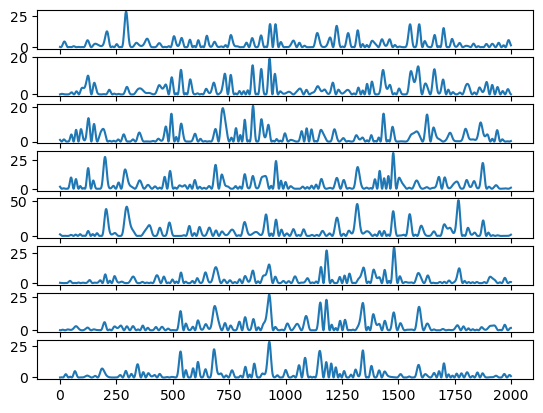

In [12]:
for i in range(len(x)):
    plt.subplot(8,1,i+1)
    plt.plot(x[i])
plt.show()

# 2 
Crear una función que reciba una señal EEG de múltiples épocas, un canal, y devuelva la sumatoria de densidad espectral de potencia, para el rango de frecuencia de 13 a 30 Hz, del promedio de la densidad espectral de potencia de las diferentes épocas de la señal de análisis

In [118]:
def sum_spectraldensity(data,canal=0,paciente=0,fs=1000):
    data=data[paciente][canal,:,:]
    puntos=[]
    for punto in data:
        p=np.mean(punto)
        puntos.append(p)
    z=np.array(puntos)
    N=len(z)
    nl=np.arange(N)
    s_ksum=0
    for n in nl:
        s_k=ecu_spectraldensity(z,nl,n,N)
        s_ksum+=s_k
    frecuencia=np.linspace(0,fs,num=N)
    return s_ksum/N,frecuencia

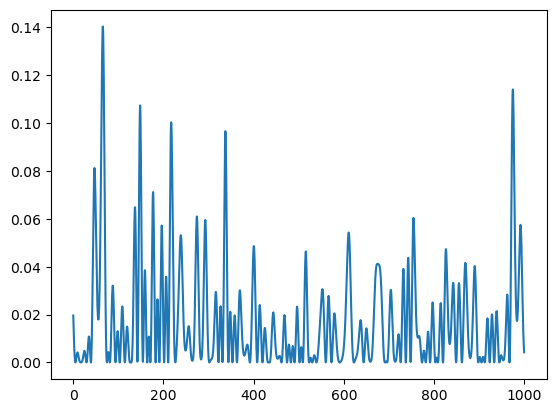

In [119]:
x,f=sum_spectraldensity(datos_matriz,0,0)
plt.plot(f,x)


In [120]:
def spectralrange(x,f,ini=13,end=30):
    bf=np.where((f>=13) &(f<=30))
    f=f[bf]
    x=x[bf]
    return f,x

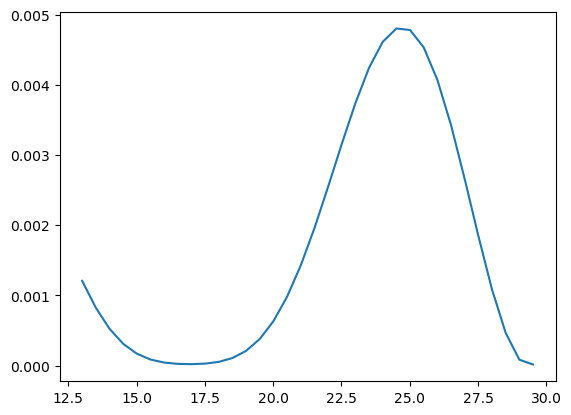

In [121]:
f,x=spectralrange(x,f,13,30)
plt.plot(f,x)

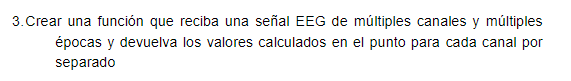

In [162]:
def PSD(xn,paciente=0):
    xn=xn[paciente]
    sums_k_list=[]
    for canal in xn:
        puntos=[]
        for punto in canal:
            p=np.mean(punto)
            puntos.append(p)
        z=np.array(puntos)
        N=len(z)
        nl=np.arange(N)
        sums_k=0
        for n in nl:
            s_k=ecu_spectraldensity(z,nl,n,N)
            sums_k+=s_k
        sums_k_list.append(sums_k/N)
    return sums_k_list

In [164]:
X=PSD(datos_matriz)

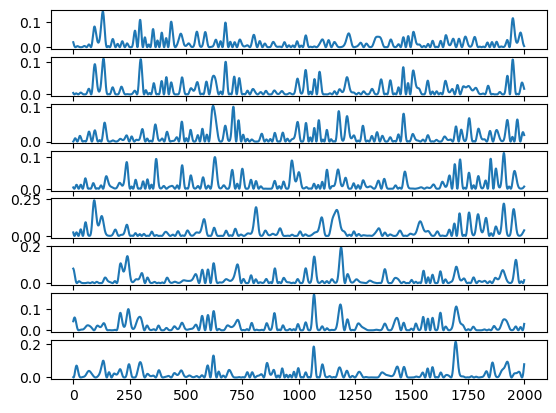

In [167]:
con=1
for i in X:
    plt.subplot(8,1,con)
    plt.plot(i)
    con+=1

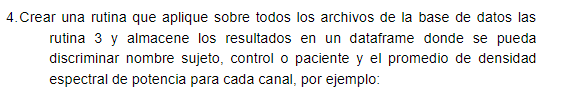

In [173]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
for i in r:
    promcanales=["Control"]
    x=PSD(datos_matriz,i)
    for canal in x:
        promcanales.append(np.mean(canal))
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))
for i in r:
    promcanales=["Parkinson"]
    x=PSD(datos_parkinson,i)
    for canal in x:
        promcanales.append(np.mean(canal))
    datosprompaciente_p.append(promcanales)

In [174]:
names = ["Estado",'C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2'] #Los nombres de las columnas
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
for paciente in datosprompaciente: #Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente (lista con primedio de cada canal) y el contador para identificar el paciente
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,C3,C1,CZ,C2,C4,O1,OZ,O2
Sujeto,,,,,,,,,
1,Control,0.017494,0.016146,0.014740,0.015860,0.031334,0.020850,0.018717,0.022129
2,Control,0.015396,0.019560,0.022466,0.019812,0.017080,0.091882,0.062923,0.068781
3,Control,0.013020,0.015650,0.023817,0.011719,0.024005,0.012075,0.013238,0.016114
4,Control,0.038417,0.033819,0.038010,0.036717,0.034113,0.090867,0.083725,0.100137
5,Control,0.016261,0.018455,0.018246,0.019087,0.022123,0.039061,0.027040,0.036252
6,Control,0.013131,0.011765,0.012101,0.008940,0.011599,0.021290,0.018564,0.020225
7,Control,0.009344,0.012022,0.016787,0.013399,0.012380,0.022589,0.015325,0.025156
8,Control,0.024607,0.022849,0.015095,0.014921,0.021301,0.084676,0.056674,0.048456
9,Control,0.006907,0.009977,0.012648,0.010678,0.009465,0.046328,0.040055,0.038622
